In [1]:
import pandas as pd
import numpy as np

from data_loader import data_load_and_split

big_firstMeas_train, big_secondMeas_train, big_firstMeas_test, big_secondMeas_test, trimmed_firstMeas_train, trimmed_secondMeas_train, trimmed_firstMeas_test, trimmed_secondMeas_test = data_load_and_split()

/Users/allierose/Library/CloudStorage/OneDrive-DukeUniversity/erdos/Erdos_Trees/machine_learning/data_loader.py:4: DtypeWarning: Columns (86,168,207,211,215) have mixed types. Specify dtype option on import or set low_memory=False.
  def data_load_and_split(big_data=pd.read_csv('../Data/final_big_data.csv'),
/Users/allierose/Library/CloudStorage/OneDrive-DukeUniversity/erdos/Erdos_Trees/machine_learning/data_loader.py:5: DtypeWarning: Columns (55,59,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trimmed_data= pd.read_csv('../Data/trimmed_data.csv'),


In [2]:
trimmed_firstMeas_train.info(verbose = True)
trimmed_firstMeas_train.head()

trimmed_secondMeas_train.info(verbose = True)

train1 = trimmed_firstMeas_train
train1 = train1.drop("Unnamed: 0", axis = 1)

train2 = trimmed_secondMeas_train
train2 = train2.drop("Unnamed: 0", axis = 1)

<class 'pandas.core.frame.DataFrame'>
Index: 9725 entries, 5504 to 7408
Data columns (total 67 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Unnamed: 0               9725 non-null   int64  
 1   PLOT                     9725 non-null   int64  
 2   LAT                      9725 non-null   float64
 3   LON                      9725 non-null   float64
 4   ELEV                     9725 non-null   float64
 5   COUNTYCD                 9725 non-null   int64  
 6   UNITCD                   9725 non-null   int64  
 7   PLT_CN                   9725 non-null   int64  
 8   CN                       9725 non-null   int64  
 9   PREV_TRE_CN              0 non-null      float64
 10  UNIQUE_PLOT_ID           9725 non-null   object 
 11  INVYR                    9725 non-null   int64  
 12  MEASYEAR                 9725 non-null   int64  
 13  MEASMON                  9725 non-null   int64  
 14  MEASDAY                  9

## Merging tables

In [3]:
combined_train = train1.merge(train2, left_on = "CN", right_on = "PREV_TRE_CN", suffixes = ("_pre_burn", "_post_burn"))
combined_train.dropna(axis = 1, how = "all", inplace = True)

# Checking the merge and removing redundant identifiers
assert((combined_train["CN_pre_burn"] == combined_train["PREV_TRE_CN_post_burn"]).all())
combined_train.drop("PREV_TRE_CN_post_burn", axis = 1, inplace = True)
combined_train.rename(columns={"CN_pre_burn": "CN"}, inplace = True)

# Cleaning up redundant columns
stable_features = ["PLOT", "LAT", "LON", "ELEV", "COUNTYCD", "UNITCD", "TREE", "SUBP", "UNIQUE_PLOT_ID"]
for col in stable_features:
    if bool((combined_train[col + "_pre_burn"] == combined_train[col + "_post_burn"]).all()) == False:
        print(f"Merge issue! {col} doesn't match!")
    else: 
        combined_train.drop(col+"_post_burn", axis = 1, inplace = True)
        combined_train.rename(columns={col+"_pre_burn": col}, inplace = True)

# Simplifying fire column names
for num in ["1","2","3"]:
    for col in ["INCIDENT", "FIREYEAR", "AREA", "PERIM"]:
        combined_train.rename(columns={col+num+"_post_burn": col+num}, inplace = True)


combined_train.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9725 entries, 0 to 9724
Data columns (total 93 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PLOT                               9725 non-null   int64  
 1   LAT                                9725 non-null   float64
 2   LON                                9725 non-null   float64
 3   ELEV                               9725 non-null   float64
 4   COUNTYCD                           9725 non-null   int64  
 5   UNITCD                             9725 non-null   int64  
 6   PLT_CN_pre_burn                    9725 non-null   int64  
 7   CN                                 9725 non-null   int64  
 8   UNIQUE_PLOT_ID                     9725 non-null   object 
 9   INVYR_pre_burn                     9725 non-null   int64  
 10  MEASYEAR_pre_burn                  9725 non-null   int64  
 11  MEASMON_pre_burn                   9725 non-null   int64

## On to the data science!

In [4]:
combined_train["YRS_SINCE_BURN"] = combined_train["MEASYEAR_post_burn"] - combined_train["FIREYEAR3"]
combined_train.loc[combined_train["YRS_SINCE_BURN"].isna(), "YRS_SINCE_BURN"]= combined_train["MEASYEAR_post_burn"] - combined_train["FIREYEAR2"]
combined_train.loc[combined_train["YRS_SINCE_BURN"].isna(), "YRS_SINCE_BURN"]= combined_train["MEASYEAR_post_burn"] - combined_train["FIREYEAR1"]

combined_train["Number_of_Fires"] =combined_train[["FIREYEAR1","FIREYEAR2","FIREYEAR3"]].notna().sum(axis=1)
combined_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9725 entries, 0 to 9724
Data columns (total 95 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   PLOT                               9725 non-null   int64  
 1   LAT                                9725 non-null   float64
 2   LON                                9725 non-null   float64
 3   ELEV                               9725 non-null   float64
 4   COUNTYCD                           9725 non-null   int64  
 5   UNITCD                             9725 non-null   int64  
 6   PLT_CN_pre_burn                    9725 non-null   int64  
 7   CN                                 9725 non-null   int64  
 8   UNIQUE_PLOT_ID                     9725 non-null   object 
 9   INVYR_pre_burn                     9725 non-null   int64  
 10  MEASYEAR_pre_burn                  9725 non-null   int64  
 11  MEASMON_pre_burn                   9725 non-null   int64

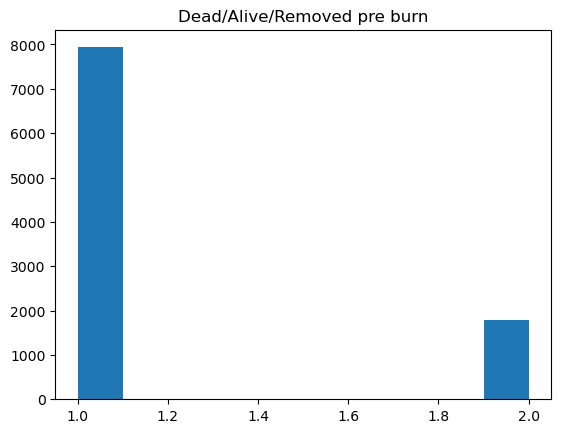

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.hist(combined_train["STATUSCD_pre_burn"])
plt.title("Dead/Alive/Removed pre burn")
plt.show()

There are a good number of dead trees pre burn (code 2), so let's get rid of those rows. Also, let's remove the trees where the status code is 0 or 3 post burn, meaning they were not reported (code 0) or they were removed by humans (code 3).

In [6]:
combined_train_cleaned_statuscode=combined_train[~((combined_train['STATUSCD_pre_burn'] ==2) | (combined_train['STATUSCD_post_burn']==3) | (combined_train['STATUSCD_post_burn']==0))]
combined_train_cleaned_statuscode=combined_train_cleaned_statuscode.dropna(subset=["ELEV", "YRS_SINCE_BURN","HT_pre_burn","Number_of_Fires","CULL_pre_burn"])

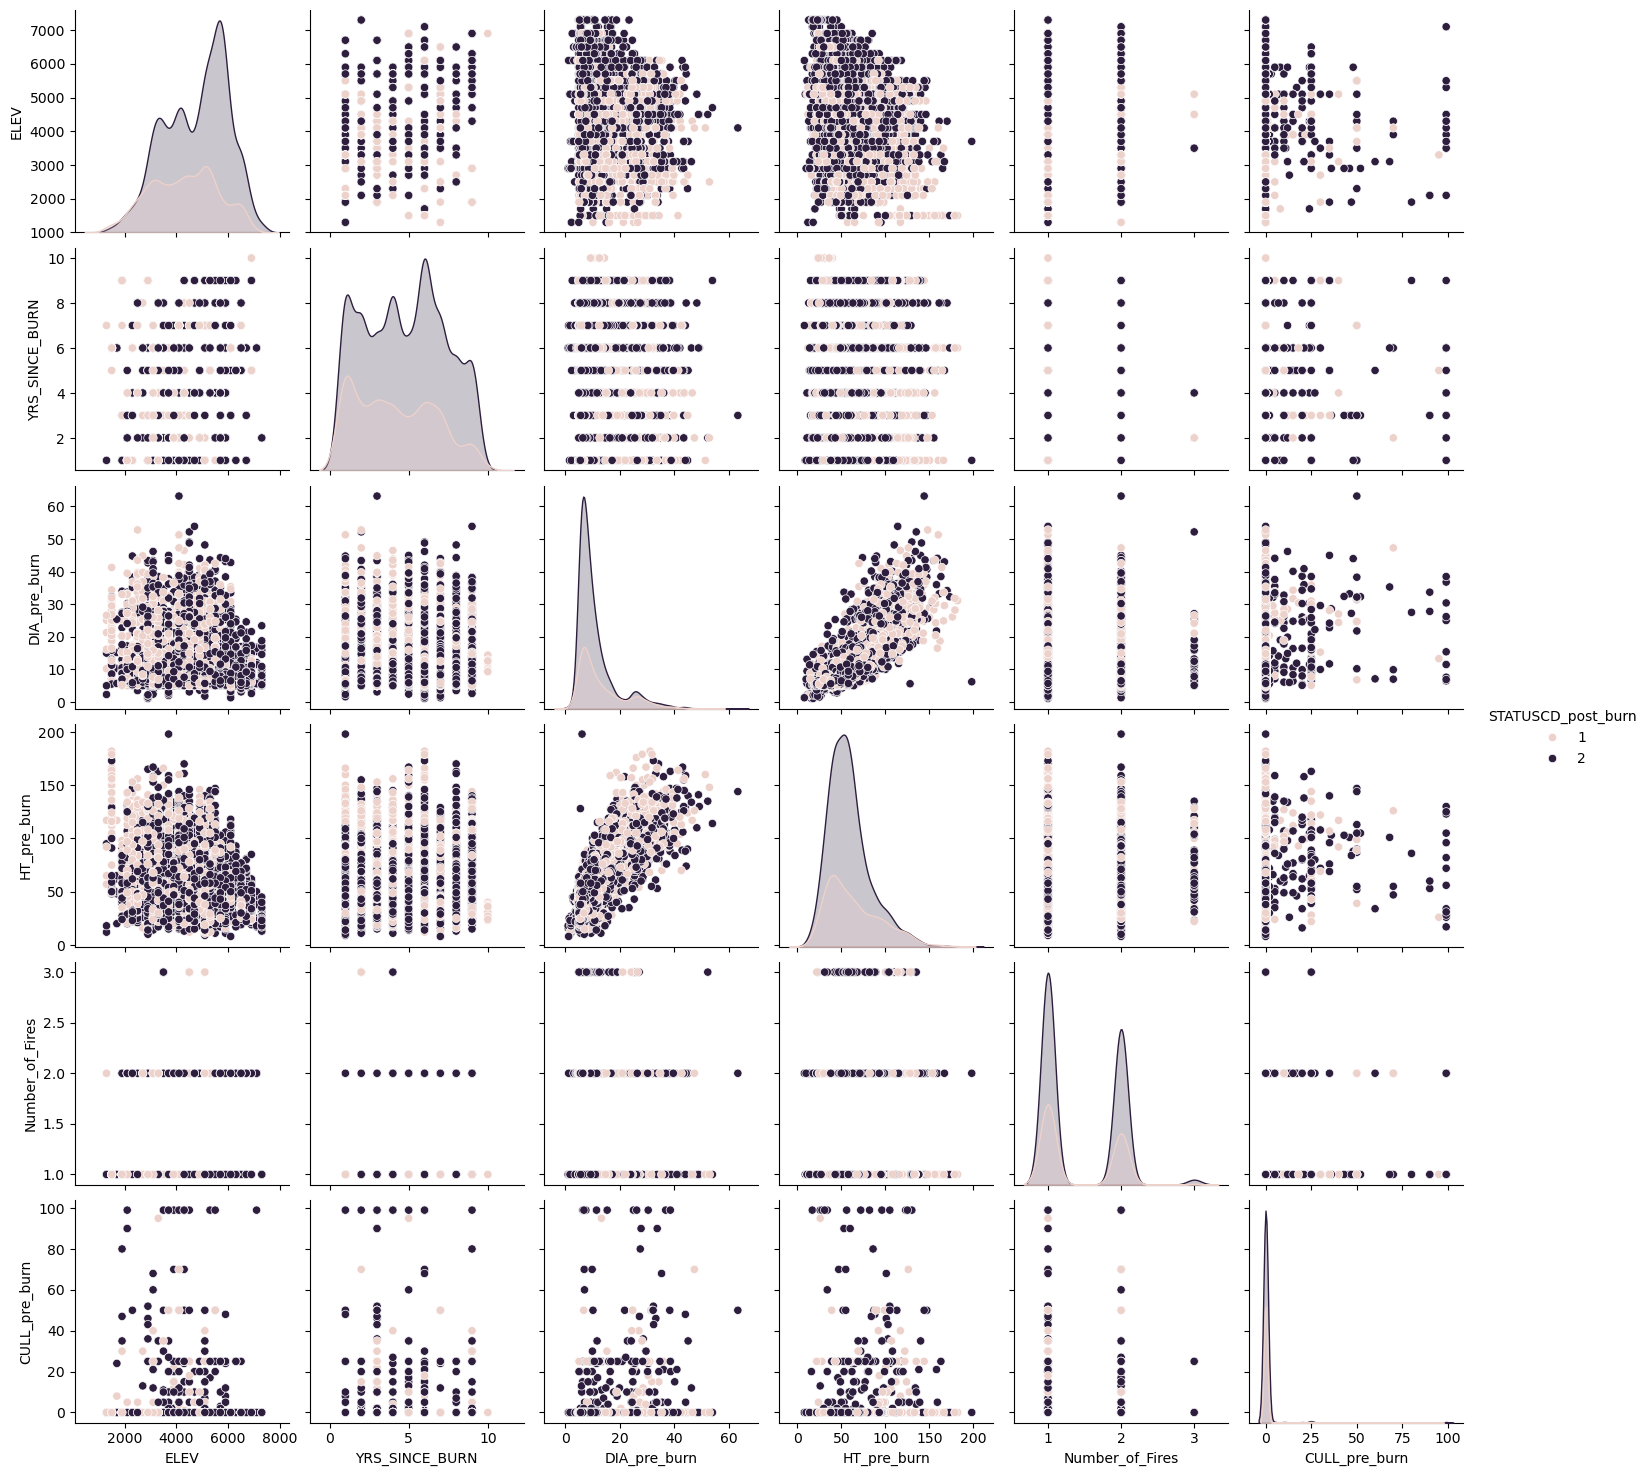

In [7]:
sns.pairplot(combined_train_cleaned_statuscode[["ELEV", "YRS_SINCE_BURN","DIA_pre_burn","HT_pre_burn","Number_of_Fires","CULL_pre_burn","STATUSCD_post_burn"]],hue="STATUSCD_post_burn")

Based on these plots, we could maybe do some classification methods using diameter, height, cull damage, number of fires, and years since burn. However, diameter and height look to be highly correlated, so let's only use one. Also, it looks like a linear decision line could be drawn between height/diameter and elevation nicely.

In [8]:
indicator_features = ["ELEV", "YRS_SINCE_BURN","HT_pre_burn","Number_of_Fires","CULL_pre_burn"]

**SVC**

In [9]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [10]:
n_splits = 5

## Make the kfold object
kfold = StratifiedKFold(n_splits, 
                        random_state=216, 
                        shuffle=True)
Cvalues = [.01, .1, 1, 10, 25, 50, 75, 100, 125, 150]
C_accuracies = np.zeros((n_splits, len(Cvalues)))
for i,(train_index, test_index) in enumerate(kfold.split(combined_train_cleaned_statuscode[indicator_features],combined_train_cleaned_statuscode['STATUSCD_post_burn'])):
    trees_tt = combined_train_cleaned_statuscode.iloc[train_index]
    trees_ho = combined_train_cleaned_statuscode.iloc[test_index]
    for j,C in enumerate(Cvalues):
        pipe = Pipeline([('scale', StandardScaler()),
                            ('svm', SVC(C=C))])
    
        pipe.fit(trees_tt[indicator_features],
                    trees_tt['STATUSCD_post_burn'])
    
        pred = pipe.predict(trees_ho[indicator_features])

        C_accuracies[i, j] = accuracy_score(trees_ho['STATUSCD_post_burn'], pred)

In [11]:
# Find optimal C
mean_cv_accuracy = np.mean(C_accuracies, axis=0)
optimal_index = np.argmax(mean_cv_accuracy)
optimal_C = Cvalues[optimal_index]
optimal_accuracy = mean_cv_accuracy[optimal_index]

print(f"The optimal C was {optimal_C} which gave a mean CV accuracy of {optimal_accuracy:.3f}")

The optimal C was 50 which gave a mean CV accuracy of 0.751
